In [227]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate
from astropy.stats import sigma_clip
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('seaborn-paper')
plt.rcParams["font.family"] = "Times New Roman"
font_size = 14

## Second-Order Correction Method

Since July 2001, STIS has employed a "First-Order" Temperature Correction for its CCD Dark Rate. For an exposure taken at a random temperature, a flat scale value is uniformly applied to all pixels on the detector to correct for the dark current of the detector at that temperature. The first-order method is ignorant to differences in ideal scale value for different dark rates and for different times. With known dark rate dependence and time dependence (See darkrate_results.ipynb), a more complex "Second-Order" method attempts to improve the overall temperature correction. The second-order correction applies a specific scale value to each pixel independently based on the dark rate of the pixel (at the reference temeperature) and the date of the observation. 

Note: This is applied by interpolating across each scale value curve measurement in time. Originally, this was explored via a model (skewed-norm + linear), but due to added complexity with comparable results, it was dropped in favor of the interpolation method. If you'd like to check out the model, records of it exist in this notebook in earlier commits.

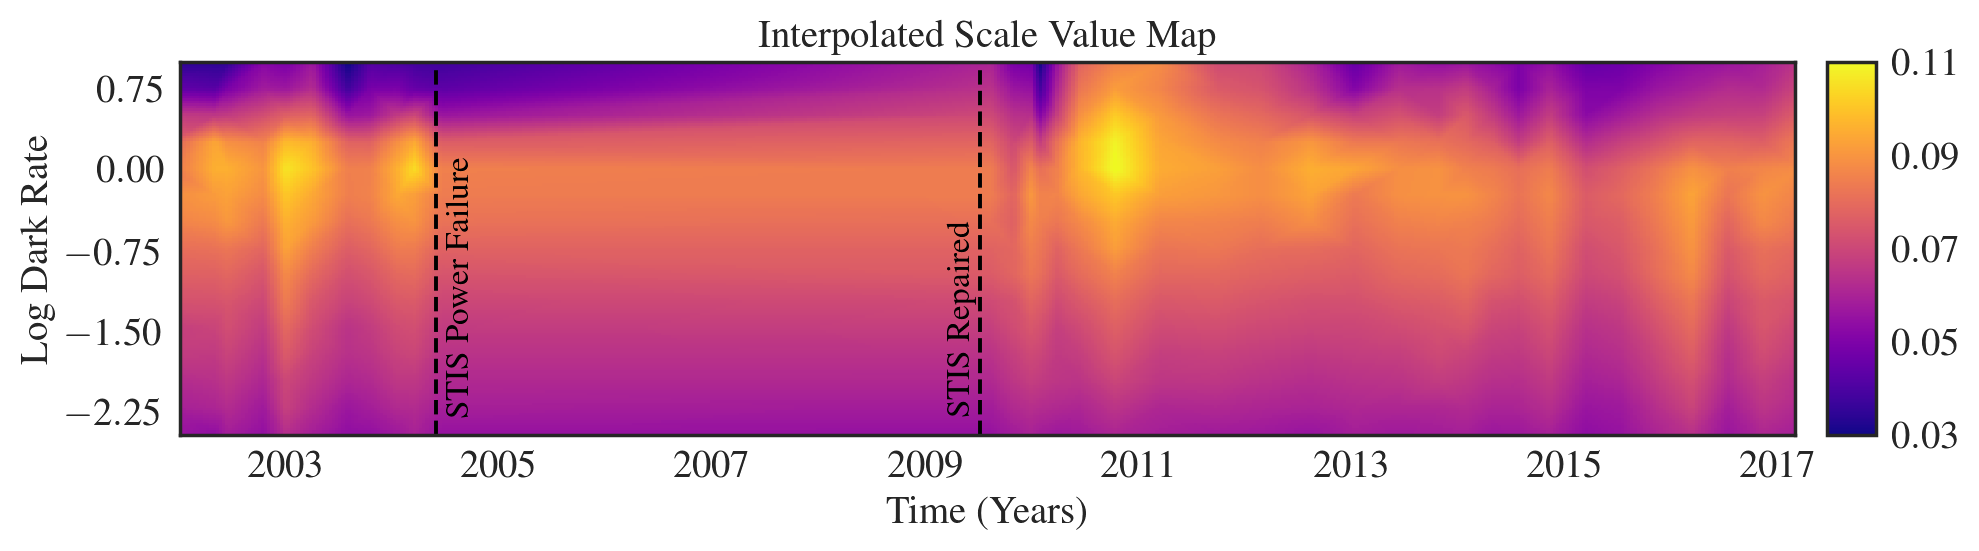

In [228]:
scale_dict = json.load(open('scaleval_data.json'))

gridpoints = np.array(np.meshgrid(scale_dict['Darkrate'],
                                  scale_dict['Datetimes'])).T.reshape(-1,2)
xlen,ylen = np.shape(scale_dict['Values'])
gridvals = np.ravel(scale_dict['Values'])

#print(interpolate.griddata(gridpoints,gridvals, [-2.6,2011.0],method = 'cubic'))

fig, (ax1) = plt.subplots(1, 1, figsize = (10,6), dpi = 200)
n = 500
m = 150
time_range = np.linspace(2002,2017.15,n)
dr_range = np.linspace(-2.5,1.0, m)
myextent  =[time_range[0],time_range[-1],dr_range[0],dr_range[-1]]


range_points = np.array(np.meshgrid(dr_range, time_range)).T.reshape(-1,2)
interp_vals = interpolate.griddata(gridpoints, gridvals, range_points, method = 'linear')
im = ax1.imshow(interp_vals.reshape(m,n), extent = myextent, cmap = 'plasma', vmin=0.03,vmax=0.11)
ax1.axvline(2004.4,0,1,color='k',linestyle = '--')
ax1.axvline(2009.5,0,1,color='k',linestyle = '--')
ax1.text(2004.63, -1.10, 'STIS Power Failure', horizontalalignment='center', 
         verticalalignment='center',rotation=90, fontsize=font_size-2, color='k')
ax1.text(2009.33, -1.4, 'STIS Repaired', horizontalalignment='center', 
         verticalalignment='center',rotation=90, fontsize=font_size-2, color='k')

plt.xticks(rotation=0, ha = 'center')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="2%")
cbar = fig.colorbar(im, cax=cax, ticks=[0.03, 0.05, 0.07, 0.09, 0.11])

ax1.set_title("Interpolated Scale Value Map")
ax1.set_ylabel("Log Dark Rate")
ax1.set_xlabel("Time (Years)")
ax1.set_yticks([-2.25,-1.5,-0.75,0,0.75])
ax1.set_xticks(np.arange(2003,2018, 2))

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(font_size)
    item.set_fontname('serif')
    
cbar.ax.tick_params(labelsize=font_size)

plt.tight_layout()
plt.savefig("Plots/interp_map.png")


